In [1]:
import numpy as np
from scipy.stats import norm, lognorm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append("..")
from src.dataset import CRKPTransmissionSimulator
from src.utils import get_results
from timeit import default_timer as timer
import matplotlib.gridspec as gs

In [2]:
## load data
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'

In [3]:
with open(f"{epi_dir}/observed_data.npy", "rb") as f:
            x_o = np.load(f)

In [4]:
infections = pd.read_csv(f"{epi_dir}/infections.csv", index_col=0)
infections.columns=np.arange(53)

## homogeneous run

In [13]:
prior_mu = -1
prior_sigma = 1

In [17]:
# best run: n_sample = 4k, d_model = 80 patience = 50
mu = 0.002
sigma = 0.169

d = norm(loc = mu, scale = sigma)
np.exp(d.ppf(0.05)), np.exp(d.ppf(0.95))

(0.7588279076341541, 1.3231036979222353)

In [15]:
np.exp(0.002 + 0.169**2/2)

1.0164137494807186

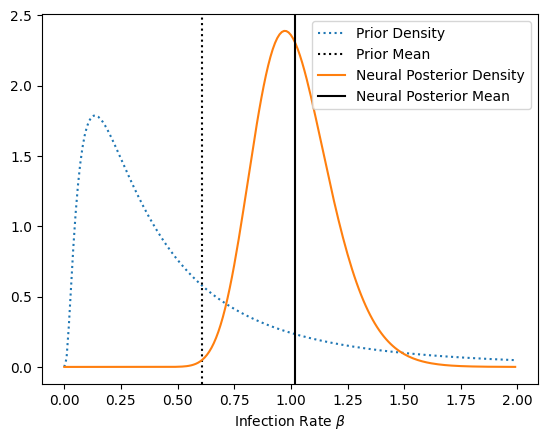

In [18]:
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
prior = norm(prior_mu, prior_sigma)
x = np.arange(0., 2, 0.01)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Neural Posterior Density")
plt.axvline(posterior_mean, color="k", label="Neural Posterior Mean")
ax.set_xlabel(r"Infection Rate $\beta$")
plt.legend()
plt.savefig("images/crkp_homog.png")
plt.show()

### data viz

In [19]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=False)
x_baseline = crkp_model.CRKP_simulator(-1e8, 100)

In [75]:
np.unique(crkp_model.F, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([41210,  1065,  1717,  1394,  1070,    10,   704]))

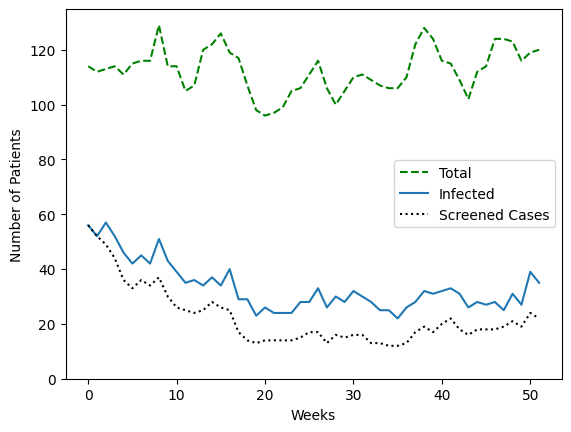

In [20]:
NN = infections.notna().sum(0)[:-1]
II = (infections == 1).sum(0)[:-1]
sns.lineplot(NN, color="green", linestyle="--", label="Total")
sns.lineplot(II, label="Infected")
sns.lineplot(x_baseline[:-1], linestyle=":", color="k", label="Screened Cases")
plt.ylim(bottom=0)
plt.ylabel("Number of Patients")
plt.xlabel("Weeks")
# plt.savefig("images/crkp.png")
plt.show()

#### posterior predictive checks

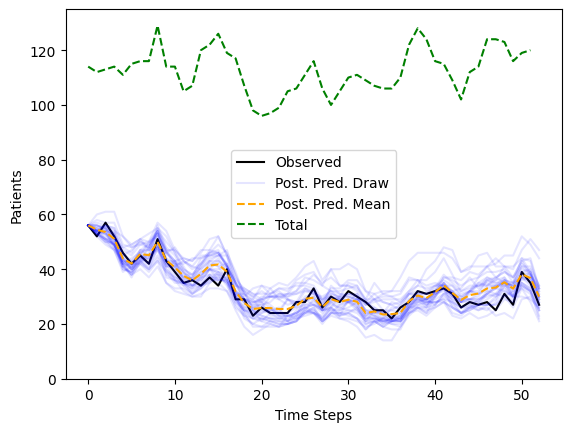

In [21]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc1.png")
plt.ylim(0, 135)
plt.show()

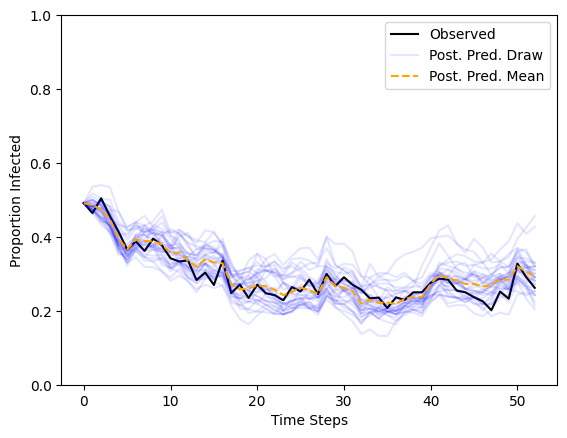

In [22]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
pop = crkp_model.W.sum(0)
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i) / pop
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0] / pop
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(x_baseline, label="Only Admitted", linestyle=":", color="k")
# plt.plot(pop, label="Population", color="g", linestyle=":")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.ylim(0, 1)
# plt.savefig("images/crkp_ppc2.png")
plt.show()

## Heterogeneous

In [57]:
prior_mu = [-1, -3, -3, 0, -3, -3, -3, 0] # [-2, -1, -1, -1, -1, -1, -1, 0] # [-1, -1, -1, -1, -1, -1, -1, -1] # 
prior_sigma = [0.3, 1, 1, 1, 1, 1, 1, 1] # [1, 1, 1, 1, 1, 1, 1, 1]

In [68]:
tag = "../outputs/2024-10-03/13-50-35" # "../outputs/2024-10-03/12-14-06"
# df_het = get_results(tag, multirun=False)
df_het = get_results("../multirun/2024-10-01/10-16-41")
df_het = df_het[df_het["mean_field"] == False]

In [69]:
mu = np.array(df_het["mu"].iloc[0][0])
sigma = np.array(df_het["sigma"].iloc[0])
rates = []
for i in range(8):
    rates.append(np.exp(mu[i] + sigma[i][i]/2))
rates = np.array(rates)

In [70]:
rates

array([0.30156333, 0.60332945, 0.3316429 , 2.38468998, 0.67764205,
       0.5022814 , 0.54450562, 2.16610984])

In [72]:
rates * np.array([60, 12, 12, 12, 12, 12, 12, 1])

array([18.09379986,  7.23995341,  3.97971478, 28.61627978,  8.13170464,
        6.0273768 ,  6.53406743,  2.16610984])

#### posterior predictive checks

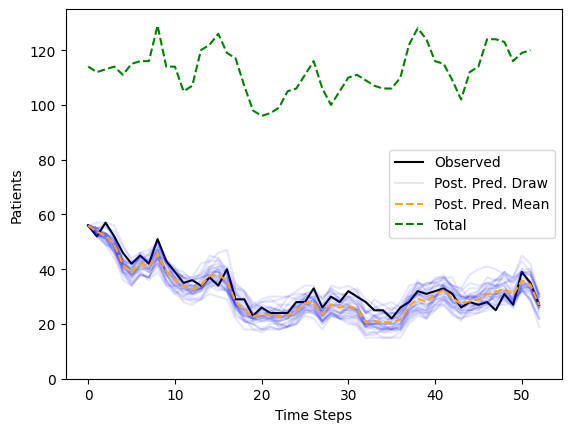

In [61]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
neural_posterior = multivariate_normal(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[0])
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc_het.png")
plt.ylim(0, 135)
plt.show()

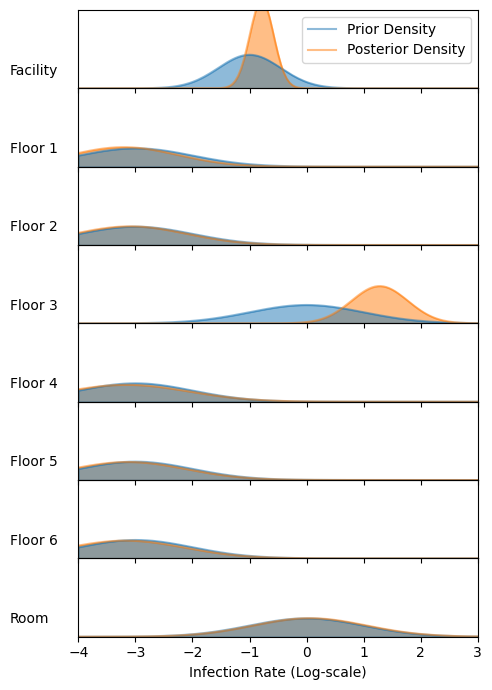

In [62]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
x = np.arange(-4, 4, 0.05)
axes = []
labels = ["Facility"] + [f"Floor {i}" for i in range(1,7)] + ["Room"]
alpha = 0.5
for i in range(8):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = norm.pdf(x, prior_mu[i], np.sqrt(prior_sigma[i]))
    posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 1.7)
    axes[-1].set_xlim(-4, 3)

    axes[-1].set_yticks([])

    if i < 8 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate (Log-scale)")

    axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(-5.2, 0.3, labels[i])
grid.update(hspace= -.0)
plt.tight_layout()
# plt.savefig("images/crkp_compare_het.png")
plt.show()
    

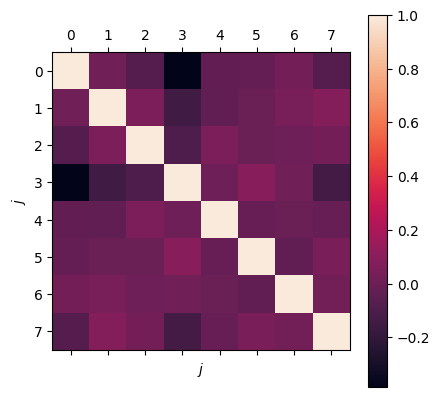

In [66]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$j$")
plt.ylabel(r"$j$")
# plt.savefig("images/corr.png")
plt.show()

#### make me a table jack

In [63]:
het_table = {"Rate": labels, 
             "Posterior Mean": np.round(np.array(rates), 3), 
             "CI": []}

for i in range(8):
    dist = norm(mu[i], np.sqrt(sigma[i][i]))
    het_table["CI"].append(
        (np.round(np.exp(dist.ppf(0.05)), 3), 
         np.round(np.exp(dist.ppf(0.95)), 3)))

In [64]:
het_table = pd.DataFrame(het_table)

In [65]:
print(het_table.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
Rate & Posterior Mean & CI \\
\midrule
Facility & 0.465000 & (0.323, 0.642) \\
Floor 1 & 0.063000 & (0.009, 0.191) \\
Floor 2 & 0.074000 & (0.009, 0.23) \\
Floor 3 & 4.067000 & (1.6, 8.104) \\
Floor 4 & 0.077000 & (0.007, 0.257) \\
Floor 5 & 0.074000 & (0.008, 0.234) \\
Floor 6 & 0.072000 & (0.008, 0.231) \\
Room & 1.738000 & (0.207, 5.439) \\
\bottomrule
\end{tabular}

